In [7]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import joblib
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 200)



In [9]:

DATASET = "diabetes"   

PATHS = {
    "diabetes":       "./diabetes.csv",
    "heart":          "./heart.csv",           
    "breast_cancer":  "./breast_cancer.csv",    



In [10]:
def load_diabetes(path):
    df = pd.read_csv(path)
    if "Outcome" not in df.columns:
        raise ValueError("Diabetes CSV must contain 'Outcome' column.")
    X = df.drop(columns=["Outcome"])
    y = df["Outcome"].astype(int)
    return X, y, "Diabetes (Pima) — Outcome=1 diabetic"

def load_heart(path):
    names = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
             "exang","oldpeak","slope","ca","thal","num"]  
    df = pd.read_csv(path, header=None, names=names, na_values=["?"])
    if "target" in df.columns:
        y = pd.to_numeric(df["target"], errors="coerce")
        X = df.drop(columns=["target"])
    else:
        y = (pd.to_numeric(df["num"], errors="coerce") > 0).astype(int)
        X = df.drop(columns=["num"])
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="ignore")
    return X, y, "Heart Disease (Cleveland) — label: disease (1) vs no disease (0)"

def load_breast_cancer(path):
    columns = [
        "ID","Diagnosis",
        "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
        "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
        "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se",
        "concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
        "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
        "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
    ]
    df = pd.read_csv(path, header=None, names=columns)
    df = df.drop(columns=["ID"])
    df["Diagnosis"] = (df["Diagnosis"].astype(str).str.strip().str.upper().map({"M":1,"B":0}))
    if df["Diagnosis"].isna().any():
        raise ValueError("Diagnosis column could not be mapped to M/B. Check your file.")
    X = df.drop(columns=["Diagnosis"])
    y = df["Diagnosis"].astype(int)
    return X, y, "Breast Cancer WDBC — Diagnosis M(1)/B(0)"

def load_dataset(key, paths):
    if key not in paths:
        raise ValueError(f"Unknown dataset key: {key}")
    path = paths[key]
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    if key == "diabetes":
        return load_diabetes(path)
    if key == "heart":
        return load_heart(path)
    if key == "breast_cancer":
        return load_breast_cancer(path)

X, y, info = load_dataset(DATASET, PATHS)
print(info)
print("Shape:", X.shape, "  Positives:", int(y.sum()), "  Negatives:", int((1-y).sum()))
X.head()





Diabetes (Pima) — Outcome=1 diabetic
Shape: (768, 8)   Positives: 268   Negatives: 500


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [11]:

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols),
])
print("Numeric features:", len(numeric_cols), "| Categorical features:", len(categorical_cols))



Numeric features: 8 | Categorical features: 0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (614, 8)  Test size: (154, 8)


In [13]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
}
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=500, max_depth=4, learning_rate=0.08,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss", random_state=42
    )
else:
    print("xgboost not installed — skipping XGBoost model.")


In [14]:
def _scores(est, X_):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X_)[:,1]
    if hasattr(est, "decision_function"):
        s = est.decision_function(X_)
        
        return (s - s.min()) / (s.max() - s.min() + 1e-9)
    return est.predict(X_)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, clf in models.items():
    pipe = ImbPipeline([
        ("prep", preprocess),
        ("smote", SMOTE(random_state=42)),   
        ("clf", clf),
    ])

    cv_res = cross_validate(
        pipe, X_train, y_train, cv=cv, n_jobs=-1,
        scoring=["accuracy","precision","recall","f1","roc_auc"],
        return_train_score=False
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_score = _scores(pipe, X_test)

    results.append({
        "model": name,
        "cv_acc":  cv_res["test_accuracy"].mean(),
        "cv_prec": cv_res["test_precision"].mean(),
        "cv_rec":  cv_res["test_recall"].mean(),
        "cv_f1":   cv_res["test_f1"].mean(),
        "cv_auc":  cv_res["test_roc_auc"].mean(),
        "test_acc":  accuracy_score(y_test, y_pred),
        "test_prec": precision_score(y_test, y_pred, zero_division=0),
        "test_rec":  recall_score(y_test, y_pred, zero_division=0),
        "test_f1":   f1_score(y_test, y_pred),
        "test_auc":  roc_auc_score(y_test, y_score),
        "pipe": pipe
    })

pd.DataFrame([{k:v for k,v in r.items() if k!="pipe"} for r in results]) \
  .sort_values("test_auc", ascending=False)


,model,cv_acc,cv_prec,cv_rec,cv_f1,cv_auc,test_acc,test_prec,test_rec,test_f1,test_auc
0,LogisticRegression,0.765427,0.646419,0.733666,0.685630,0.833542,0.740260,0.612903,0.703704,0.655172,0.820370
2,RandomForest,0.770332,0.669975,0.682171,0.675059,0.816244,0.720779,0.587302,0.685185,0.632479,0.813148
3,XGBoost,0.731254,0.609096,0.654264,0.629992,0.783693,0.733766,0.610169,0.666667,0.637168,0.807593
1,SVM-RBF,0.754018,0.630912,0.733555,0.675950,0.836505,0.707792,0.558442,0.796296,0.656489,0.786667


Best by ROC-AUC: LogisticRegression  (Test ROC-AUC = 0.820)


<Figure size 640x480 with 0 Axes>

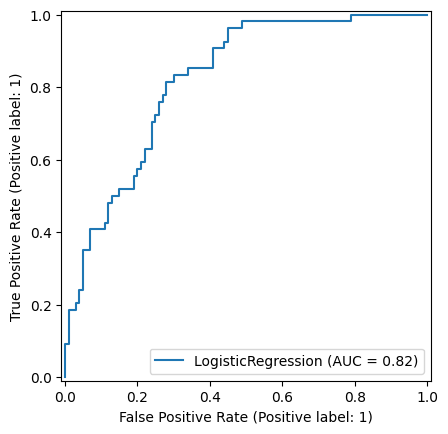

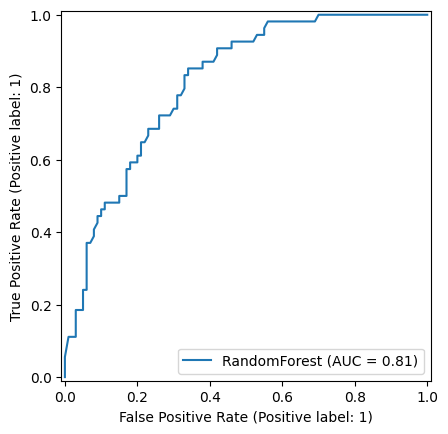

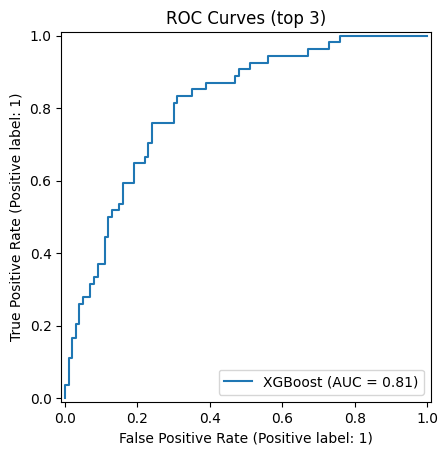

<Figure size 640x480 with 0 Axes>

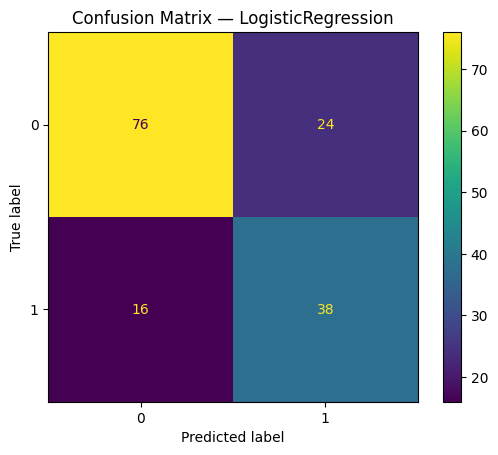

Classification report (best model):

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       100
           1       0.61      0.70      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154



In [15]:
best = max(results, key=lambda d: d["test_auc"])
best_name, best_pipe = best["model"], best["pipe"]
print(f"Best by ROC-AUC: {best_name}  (Test ROC-AUC = {best['test_auc']:.3f})")

# ROC curves
plt.figure()
for r in sorted(results, key=lambda d: d["test_auc"], reverse=True)[:3]:
    RocCurveDisplay.from_estimator(r["pipe"], X_test, y_test, name=r["model"])
plt.title("ROC Curves (top 3)")
plt.show()

# Confusion matrix for best
plt.figure()
ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

print("Classification report (best model):\n")
print(classification_report(y_test, best_pipe.predict(X_test)))


In [16]:
os.makedirs("models", exist_ok=True)
tag = DATASET
model_path = f"models/best_{best_name.lower().replace(' ','_')}_{tag}.joblib"
joblib.dump(best_pipe, model_path)
print("Saved:", model_path)


Saved: models/best_logisticregression_diabetes.joblib


In [18]:

example = X_test.iloc[[1]].copy()
proba = best_pipe.predict_proba(example)[:,1][0] if hasattr(best_pipe, "predict_proba") else None
pred  = int(best_pipe.predict(example)[0])
print("Prediction:", pred, "  Probability of disease:" , None if proba is None else round(float(proba), 3))
example


Prediction: 0   Probability of disease: 0.132


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
672,10,68,106,23,49,35.5,0.285,47
